In [ ]:
! pip install umap-learn

In [ ]:
import umap as ump
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
from google.colab import drive
import os
from os import listdir

print('Successful imports')

Successful imports


In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd '/content/gdrive/MyDrive/Machine Learning in healthcare/Final project'

/content/gdrive/MyDrive/Machine Learning in healthcare/Final project


 ### IDEAS

 CLUSTERING - GMM

 DIMENSIONALITY REDUCTION - Umap + plot to observe data separation in latent space

 Study pairwise mutual information + HSIC + correlations

 Association rules, observe what usually goes together A PRIORI

 Graph analysis on graph version of latent space and run algorithms for strongly connected components. Something that accounts for intra-class noise and difference between other classes (or clusters)



## Feature selection

In [ ]:
data = pd.read_csv('Eureca_Adapted.csv', low_memory=False)

In [ ]:
all = data.columns
cols = []

In [ ]:
# series of interesting information,
mixture = ['type', 'suicide','EST_CIV', 'children', 'ideation_of_suicide', 'desire_of_death', 'Planification_of_suicide', 'tm', 'tm2',
        'tabacco_act', 'niv_edu','his_fam_suicide_behavior', 'his_fam_suicide', 'his_fam_suicide_attempt',
        'desire_of_death', 'Planification_of_suicide', 'dd_depre', 'dd_bipolar', 'dd_sz', 'dd_psychotic']

In [ ]:
# BDHI and BIS scales
BDHIS = [col for col in all if ("BDHI_" in col)] # usando subtotales BDHI_,
BIS = [col for col in all if ("BIS10_" in col)] # cogemos subtotales latentes BIS, resultado final es suma de los tres subtotales



In [ ]:
print(BDHIS)
print(BIS)

['BDHI_Impul', 'BDHI_Hostind', 'BDHI_Irritab', 'BDHI_Negativ', 'BDHI_Ressent', 'BDHI_Suspic', 'BDHI_Hostivb', 'BDHI_Culpab']
['BIS10_Impulc', 'BIS10_Impulm', 'BIS10_impulnp']


In [ ]:
# polymorphisms and other data are in the last 30 variables
extra = list(data.columns[-30:])
for col in mixture +  BDHIS +  BIS + extra:
  cols.append(col)


In [ ]:
print(f"Original data dimension: {len(all)}")
print(f"Current subset dimension: {len(cols)}")


Original data dimension: 604
Current subset dimension: 61


In [ ]:
reducedFeatures = mixture + BIS + BDHIS + extra
# save feature subset
subset = data[reducedFeatures]
subset['BIS'] = subset[BIS[0]] + subset[BIS[1]] + subset[BIS[2]]
subset.drop(columns=BIS, inplace=True)

subset.to_csv('Eureca2.0.csv', index=False)

<ipython-input-12-ed54b08e2e16>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['BIS'] = subset[BIS[0]] + subset[BIS[1]] + subset[BIS[2]]
<ipython-input-12-ed54b08e2e16>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.drop(columns=BIS, inplace=True)


## Exploratory Data analysis: Understanding of our data

## Patient profiling

In this section we profile patients based on different clustering and dimensionality reduction schemes.

In [ ]:
# reading feature subset
df = pd.read_csv('Eureca2.0.csv')

In [ ]:
df.head()

,type,suicide,EST_CIV,children,ideation_of_suicide,desire_of_death,Planification_of_suicide,tm,tm2,tabacco_act,...,TPH1_T8687,TPH2_8997,TPH2_9000_Eco72_1,TPH2_9000_Aci_I,TPH2_Intron5,TPH2_Exon7,TPH2_Intron9,MAOA_Promo,MAOA_promo_activite,BIS
0,12,0,2,1,2,2,2,1,,1,...,,,AA,GG,,GG,,2 3,B H,311228
1,7,,,1,,2,,1,,,...,,,AA,,,AG,,2,H,281931
2,12,0,2,1,2,2,2,1,,0,...,,,AA,GG,,GG,,2,H,152418
3,12,0,2,1,1,1,0,1,,1,...,,,,,,,,,,40
4,11,,3,,,,,1,,,...,,,,,,,,2,H,


#### UMAP + GMM


UMAP works by modeling the relationships between data points in the high-dimensional space and finding a low-dimensional representation that preserves these relationships. Unlike traditional methods like t-SNE, UMAP provides a more scalable and computationally efficient solution.


______
1. The first issue tackled lies in the fact that UMAP only works with numeric variables, but that is not the case in our dataset. The variables corresponding to the polymorphisms take a very small subset of different nucleotide combinations, dummy variable encoding is therefore used.

WRONG

In [ ]:
from transformers import AutoTokenizer, AutoModel

class Embedder:
    def __init__(self, model_name, num_components=1, max_length=32):
        self.model = AutoModel.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.num_components = num_components
        self.max_length = max_length

    def _get_bert_embeddings(self, documents):
        tokenized_texts = [self.tokenizer(document, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length) for document in documents]
        input_ids = torch.cat([t['input_ids'] for t in tokenized_texts], dim=0)
        attention_mask = torch.cat([t['attention_mask'] for t in tokenized_texts], dim=0)

        with torch.no_grad():
            output = self.model(input_ids, attention_mask=attention_mask)

        embeddings = output.last_hidden_state.mean(dim=1).numpy()
        print('Embeddings successfully completed')
        return embeddings
    def fit_transform(self, documents):
        embeddings = self._get_bert_embeddings(documents)

        # Reduce dimensionality to 1D using PCA
        pca = PCA(n_components=self.num_components)
        reduced_embeddings = pca.fit_transform(embeddings)

        return reduced_embeddings


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Function to handle numeric or text embedding based on column type
def embed_column(column):
    try:
        # Try to convert the column to numeric
        numeric_column = pd.to_numeric(column)
        return numeric_column
    except ValueError:
        # If conversion fails, compute text embedding using TF-IDF
        tfidf_vectorizer = TfidfVectorizer()
        text_embedding = tfidf_vectorizer.fit_transform(column.astype(str))
        return pd.DataFrame(text_embedding.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


In [ ]:
df_encoded = df.copy()

# Identify string columns
string_columns = df.select_dtypes(include=['object']).columns

# Encode each string column using dummy variables and concatenate the results
for col in string_columns:
    dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
    print(dummies)
    break

# Drop the original string columns
df_encoded = df_encoded.drop(string_columns, axis=1)


In [ ]:
# Identify string columns
string_columns = df.select_dtypes(include=['object']).columns

# Encode string columns using dummy variables
df_encoded = pd.get_dummies(df, columns=string_columns, drop_first=True)

# saving encoded version
df_encoded.to_csv('Eureca2.0_embed.csv')

In [ ]:
len(df_encoded.columns)

3362

In [ ]:
df_encoded['BIS_9624'].value_counts()

0    8694
1       1
Name: BIS_9624, dtype: int64

In [ ]:
# df_encoded = pd.read_csv('Eureca2.0_embed.csv')
reducer = ump.UMAP()
embeddings = reducer.fit_transform(df_encoded)


Studying the correlations between the original features and the UMAP dimensions, helps to understand which variables have the most impact in the components of the reduced data. The following code displays, for both components, the 10 features with the highest correlation with the UMAP component in absolute value

In [ ]:
correlations = np.zeros((df_encoded.shape[1], embeddings.shape[1]))

# Calculate correlations
for i in range(df.shape[1]):
    for j in range(embeddings.shape[1]):
        correlations[i, j] = np.corrcoef(df_encoded.iloc[:, i], embeddings[:, j], rowvar=False)[0, 1]

# Create DataFrames to store the results for UMAP1 and UMAP2
correlation_df_umap1 = pd.DataFrame(correlations[:, 0], columns=['UMAP1'], index=df_encoded.columns)
correlation_df_umap2 = pd.DataFrame(correlations[:, 1], columns=['UMAP2'], index=df_encoded.columns)

# Get top 10 correlations for UMAP1
top_correlations_umap1 = correlation_df_umap1.abs().nlargest(10, 'UMAP1')

# Print the top 10 correlations with sign for UMAP1
print("UMAP1:")
for feature, correlation in top_correlations_umap1.iterrows():
    sign = '-' if correlation_df_umap1.loc[feature, 'UMAP1'] < 0 else '+'
    print(f"Feature: {feature}, Correlation: ({sign}) {correlation['UMAP1']:.4f}")

# Get top 10 correlations for UMAP2
top_correlations_umap2 = correlation_df_umap2.abs().nlargest(10, 'UMAP2')

# Print the top 10 correlations with sign for UMAP2
print("\nUMAP2:")
for feature, correlation in top_correlations_umap2.iterrows():
    sign = '-' if correlation_df_umap2.loc[feature, 'UMAP2'] < 0 else '+'
    print(f"Feature: {feature}, Correlation: ({sign}) {correlation['UMAP2']:.4f}")

In [ ]:

# UMAP + GMM clustering through optimal Bayesian Information Criterion


# we need to encode string variables

bics = []
ls =[] # likelihoods
lls = [] # log-likelihoods
aics = []
ks = range(1,7)
for ns in ks:
  gmm = GMM(n_components=ns, random_state=42)
  gmm.fit(embeddings)
  bics.append(gmm.bic(embeddings))
  aics.append(gmm.aic(embeddings))
  ls.append(gmm.score_samples(embeddings).mean())
  lls.append(gmm.score(embeddings))

opt = ks[bics.index(min(bics))]
gmm = GMM(n_components=opt, random_state=42)
labs = gmm.fit_predict(embeddings)
dfr = pd.DataFrame(embeddings, columns=['UMAP1', 'UMAP2'])
dfr['profile'] = labs


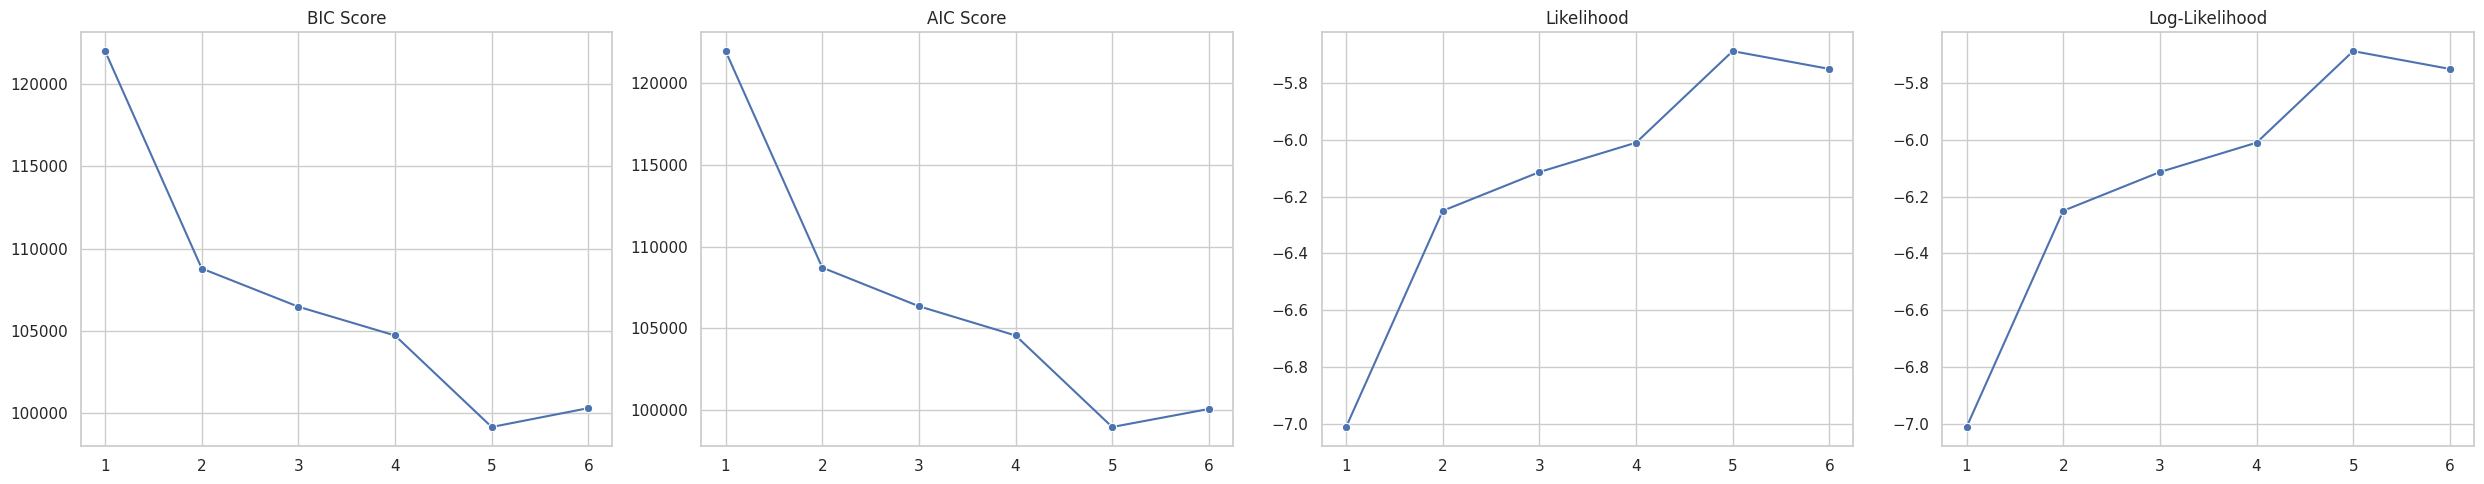

In [ ]:
plt.figure(figsize=(25, 5))

# BIC Plot
plt.subplot(1, 4, 1)
sns.lineplot(x=ks, y=bics, marker='o')
plt.title('BIC Score')

# AIC Plot
plt.subplot(1, 4, 2)
sns.lineplot(x=ks, y=aics, marker='o')
plt.title('AIC Score')

# Likelihood Plot
plt.subplot(1, 4, 3)
sns.lineplot(x=ks, y=ls, marker='o')
plt.title('Likelihood')

# Log-Likelihood Plot
plt.subplot(1, 4, 4)
sns.lineplot(x=ks, y=lls, marker='o')
plt.title('Log-Likelihood')

plt.tight_layout()
plt.show()

The optimal value for the components is the same for all criteria, since the best number of components for BIC and AIC is the one that minimizes it and for the likelihoods the one that maximizes it.

In [ ]:
dfr['profile'].value_counts()

0    2439
3    2399
1    2015
2     931
4     911
Name: profile, dtype: int64

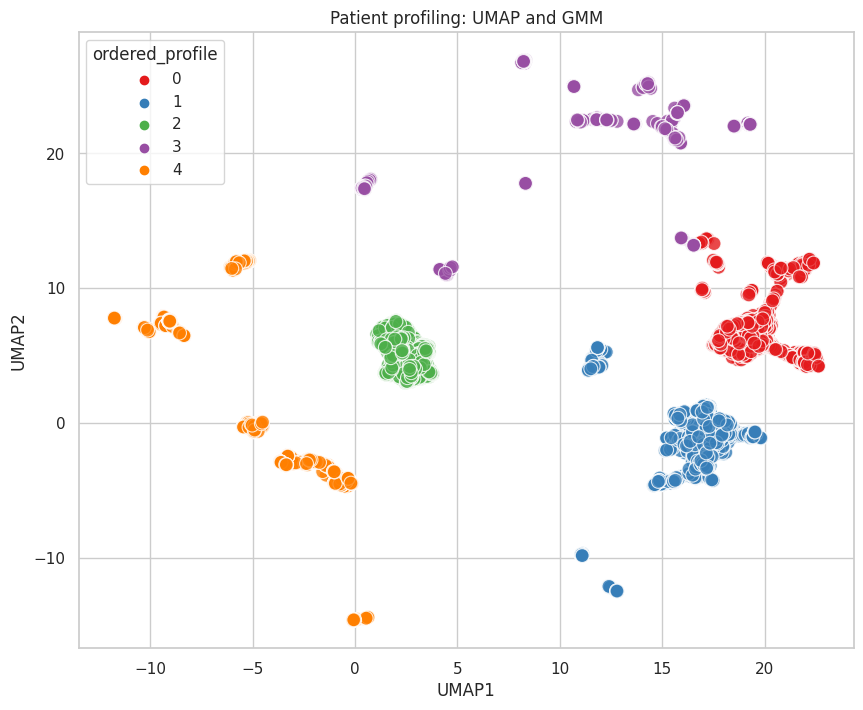

In [ ]:
dfr.to_csv('Eureca2.0_umapGMM.csv')
cdg =  dfr['profile'].value_counts(normalize=True)
ordered_cluster_indices = cdg.index
dfr['ordered_profile'] = dfr['profile'].map(dict(zip(ordered_cluster_indices, range(len(ordered_cluster_indices)))))

sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='ordered_profile', data=dfr, palette="Set1", s=100, alpha=0.8)
plt.title('Patient profiling: UMAP and GMM')
plt.show()

We now commence by analyzing the results.

In [ ]:
cluster_distribution_gmm = dfr['profile'].value_counts(normalize=True)
print("Cluster Distribution (GMM):")
print(cdg)

Cluster Distribution (GMM):
0    0.280506
3    0.275906
1    0.231742
2    0.107073
4    0.104773
Name: profile, dtype: float64


Three dominant patient profiles are observed that hoard almost 80% of samples. Note that when extending the previous procedure for a wider array of values of components this fact persists, e.g., when studying the best fitting GMM up to 11 components these three dominant clusters take up approximately 75% of samples.

In [ ]:
cluster_centers_gmm = pd.DataFrame(gmm.means_, columns=['UMAP1', 'UMAP2'])
cluster_covariance_gmm = gmm.covariances_

print("\nCluster Centers (GMM):")
print(cluster_centers_gmm)
print("\nCluster Covariance Matrices (GMM):")
for i, cov_matrix in enumerate(cluster_covariance_gmm):
    print(f"\nCluster {i} Covariance Matrix:")
    print(cov_matrix)


Cluster Centers (GMM):
       UMAP1      UMAP2
0  19.608700   7.228430
1   2.386636   5.248012
2  10.006203  20.764166
3  16.346813  -1.379043
4  -4.700123   1.164582

Cluster Covariance Matrices (GMM):

Cluster 0 Covariance Matrix:
[[1.66455353 0.22034001]
 [0.22034001 4.58904196]]

Cluster 1 Covariance Matrix:
[[ 0.44862204 -0.32521815]
 [-0.32521815  1.53761958]]

Cluster 2 Covariance Matrix:
[[38.88574575 14.7137841 ]
 [14.7137841  20.45357407]]

Cluster 3 Covariance Matrix:
[[ 3.76159925  0.93146388]
 [ 0.93146388 11.40916722]]

Cluster 4 Covariance Matrix:
[[ 12.5021456  -20.65931056]
 [-20.65931056  51.5868798 ]]


All of the profiles, except for have strongly anisotropic covariance matrices, for example the fifth one is very stretched out along the UMAP2 dimension, of the dominant profiles, cluster 3 is the most anisotropic and cluster 1 is the least, as it is nearly isotropic.